In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

df = pd.read_csv("Diabetes-Classification.csv")
df.head()

,Age,Gender,BMI,Blood Pressure,FBS,HbA1c,Family History of Diabetes,Smoking,Diet,Exercise,Diagnosis
0,45,Male,25.0,Normal,100,5.7,No,No,Healthy,Regular,No
1,55,Female,30.0,High,120,6.4,Yes,Yes,Poor,No,Yes
2,65,Male,35.0,High,140,7.1,Yes,Yes,Poor,No,Yes
3,75,Female,40.0,High,160,7.8,Yes,Yes,Poor,No,Yes
4,40,Male,20.0,Normal,80,5.0,No,No,Healthy,NaN,No


In [2]:
df = df.dropna()
df.isnull().sum()

Age                           0
Gender                        0
BMI                           0
Blood Pressure                0
FBS                           0
HbA1c                         0
Family History of Diabetes    0
Smoking                       0
Diet                          0
Exercise                      0
Diagnosis                     0
dtype: int64

In [3]:
# Preprocessing
cat_cols = ["Gender", "Blood Pressure", "Family History of Diabetes", "Smoking", "Diet", "Exercise"]
num_cols = ["Age", "BMI", "FBS", "HbA1c"]

# Create a column transformer 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer(transformers = [('num', StandardScaler(), num_cols), ('cat', OneHotEncoder(handle_unknown = 'ignore'), cat_cols)])


In [4]:
# Train test split
from sklearn.model_selection import train_test_split

X = df.drop("Diagnosis", axis = 1)
y = df["Diagnosis"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [5]:
# Apply preprocessing
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

y_train = y_train.map({'No': 0, 'Yes': 1}).values
y_test = y_test.map({'No': 0, 'Yes': 1}).values

In [6]:
# Convert X_train_scaled and X_test_scaled to NumPy arrays - for TensorFlow compatability
X_train_scaled = X_train_scaled.astype('float32')
X_test_scaled = X_test_scaled.astype('float32')

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input

#suppress warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Build the TensorFlow MLP model
tf_model = Sequential([
    Input(shape = (X_train_scaled.shape[1],)),
    Dense(64, activation = 'relu'),
    Dropout(0.2),
    Dense(32, activation = 'relu'),
    Dropout(0.2),
    Dense(1, activation = 'sigmoid')
])

In [8]:
# Initialise the model
tf_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy' , tf.keras.metrics.AUC(name='auc')])

# Train the model
history = tf_model.fit(X_train_scaled, y_train, epochs = 50, batch_size = 32, validation_split = 0.2, verbose = 1)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 271ms/step - accuracy: 0.7692 - auc: 0.6240 - loss: 0.5354 - val_accuracy: 0.6471 - val_auc: 0.6515 - val_loss: 0.6230
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7692 - auc: 0.5440 - loss: 0.5371 - val_accuracy: 0.6471 - val_auc: 0.6970 - val_loss: 0.6073
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7692 - auc: 0.7313 - loss: 0.4913 - val_accuracy: 0.6471 - val_auc: 0.7273 - val_loss: 0.5971
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7692 - auc: 0.7873 - loss: 0.4707 - val_accuracy: 0.6471 - val_auc: 0.7803 - val_loss: 0.5890
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7692 - auc: 0.7633 - loss: 0.4664 - val_accuracy: 0.6471 - val_auc: 0.7955 - val_loss: 0.5809
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7692 - auc: 0.7087 - loss: 0.4811 - val_accuracy: 0.6471 - val_auc: 0.8106 - val_loss: 0.5732
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accura

In [9]:
# Evaluating model performance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred_tf = (tf_model.predict(X_test_scaled) > 0.5).astype(int)
print("Accuracy:", accuracy_score(y_test, y_pred_tf))
print("Classification Report:", classification_report(y_test, y_pred_tf))
print("Confusion Matrix:", confusion_matrix(y_test, y_pred_tf))



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Accuracy: 0.8055555555555556
Classification Report:               precision    recall  f1-score   support

           0       0.79      1.00      0.89        27
           1       1.00      0.22      0.36         9

    accuracy                           0.81        36
   macro avg       0.90      0.61      0.62        36
weighted avg       0.85      0.81      0.75        36

Confusion Matrix: [[27  0]
 [ 7  2]]


#### Assignment 1
Deal with imbalances in the dataset

Fine tune the above neural network

Use other visualisation techniques for performance evaluation

In [10]:
# Checking for imbalances
print(df["Diagnosis"].value_counts())

Diagnosis
No     88
Yes    30
Name: count, dtype: int64


In [11]:
# Get sample weights
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(df["Diagnosis"]), y = df["Diagnosis"])
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(df["Diagnosis"]), class_weights)}

sample_weights = compute_sample_weight(class_weight = class_weights_dict, y = df["Diagnosis"]) 

class_weights_dict


{'No': np.float64(0.6704545454545454), 'Yes': np.float64(1.9666666666666666)}

In [16]:
# Train model on sample weights and fine tune
# learning rate, more layers or units, early stopping

# train-test split (with scaled data and sample weights)
X_train, X_test, y_train, y_test, sw_train, sw_test = train_test_split(X, y, sample_weights, test_size = 0.3, random_state = 42)
# apply preprocessing
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

y_train = y_train.map({'No': 0, 'Yes': 1}).values
y_test = y_test.map({'No': 0, 'Yes': 1}).values

# Compile models
tf_unweighted = Sequential([
    Input(shape = (X_train_scaled.shape[1],)),
    Dense(64, activation = 'relu'),
    Dropout(0.2),
    Dense(32, activation = 'relu'),
    Dropout(0.2),
    Dense(1, activation = 'sigmoid')
])

tf_weighted = Sequential([
    Input(shape = (X_train_scaled.shape[1],)),
    Dense(64, activation = 'relu'),
    Dropout(0.2),
    Dense(32, activation = 'relu'),
    Dropout(0.2),
    Dense(1, activation = 'sigmoid')
])

# Visualisation of model performance
def plot_history(histories, metric='auc'):
    plt.figure(figsize = (8,5))
    for name, history in histories:
        plt.plot(history.history[f'val_{metric}'], label = f'{name} (val)')
        plt.plot(history.history[metric], linestyle = '--', alpha = 0.7, label = f'{name} (train)')
    plt.xlabel('Epoch')
    plt.ylabel(metric.upper())
    plt.title(f'Model comparison ({metric.upper()}, rate = {rate})')
    plt.legend()
    plt.show()

all_histories = []
for rate in np.arange(0.0001, 0.0004, 0.0001):

    optimizer = tf.keras.optimizers.Adam(learning_rate = rate)

    tf_weighted.compile(
        optimizer = optimizer, #fine tuned
        loss = 'binary_crossentropy',
        metrics = ['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

    history_weighted = tf_weighted.fit(
        X_train_scaled, y_train,
        validation_data = (X_test_scaled, y_test, sw_test),
        epochs = 50,
        batch_size = 32,
        sample_weight = sw_train,
        verbose = 0
    )
    
    tf_unweighted.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy' , tf.keras.metrics.AUC(name='auc')])
    history = tf_unweighted.fit(
        X_train_scaled, y_train, 
        validation_data = (X_test_scaled, y_test),
        epochs = 50, 
        batch_size = 32, 
        verbose = 0
        )
   
    all_histories.append((f"Weighted lr={rate}", history_weighted, history))

# Subplots for each learning rate (AUC)
fig, axes = plt.subplots(2, 3, figsize = (16,5), sharey = True)
for idx, (name, history, weighthistory) in enumerate(all_histories):
    axes[idx].plot(history.history['val_auc'], label=f'{name} (val)')
    axes[idx].plot(history.history['auc'], linestyle='--', alpha=0.7, label=f'{name} (train)')
    axes[idx].plot(history.weighthistory['val_auc'], label=f'{name} (val)')
    axes[idx].plot(history.weighthistory['auc'], linestyle='--', alpha=0.7, label=f'{name} (train)')
    axes[idx].set_xlabel('Epoch')
    axes[idx].set_title(name)
    axes[idx].legend()
axes[0].set_ylabel('AUC')
plt.suptitle('Model comparison (AUC) for different learning rates')
plt.tight_layout()
plt.show()

NotImplementedError: numpy() is only available when eager execution is enabled.

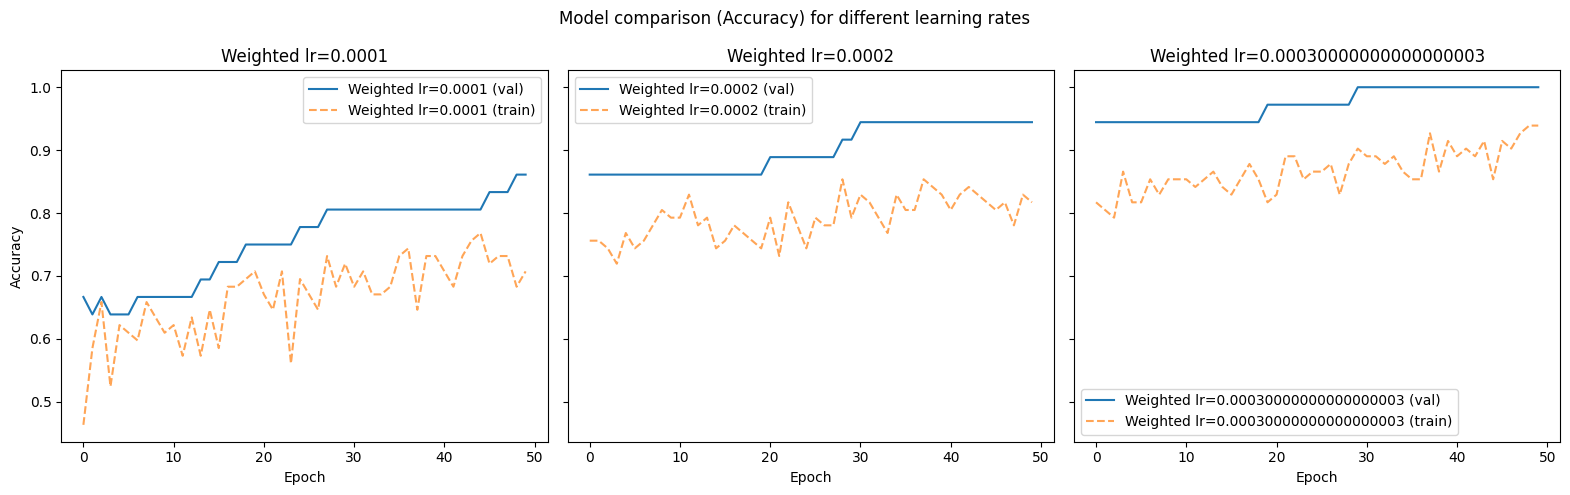

In [ ]:
# Subplots for each learning rate (Accuracy)
fig, axes = plt.subplots(1, len(all_histories), figsize=(16,5), sharey=True)
for idx, (name, history) in enumerate(all_histories):
    axes[idx].plot(history.history['val_accuracy'], label=f'{name} (val)')
    axes[idx].plot(history.history['accuracy'], linestyle='--', alpha=0.7, label=f'{name} (train)')
    axes[idx].set_xlabel('Epoch')
    axes[idx].set_title(name)
    axes[idx].legend()
axes[0].set_ylabel('Accuracy')
plt.suptitle('Model comparison (Accuracy) for different learning rates')
plt.tight_layout()
plt.show()

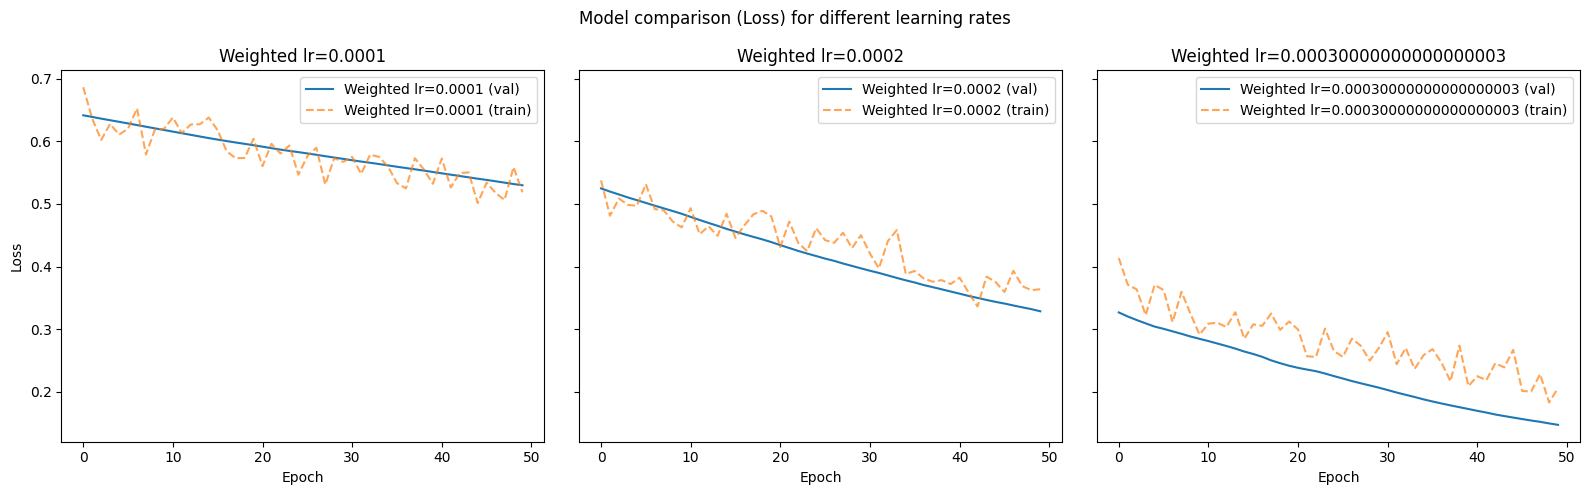

In [ ]:
# Subplots for each learning rate (Loss)
fig, axes = plt.subplots(1, len(all_histories), figsize=(16,5), sharey=True)
for idx, (name, history) in enumerate(all_histories):
    axes[idx].plot(history.history['val_loss'], label=f'{name} (val)')
    axes[idx].plot(history.history['loss'], linestyle='--', alpha=0.7, label=f'{name} (train)')
    axes[idx].set_xlabel('Epoch')
    axes[idx].set_title(name)
    axes[idx].legend()
axes[0].set_ylabel('Loss')
plt.suptitle('Model comparison (Loss) for different learning rates')
plt.tight_layout()
plt.show()

#### Conclusion for model fine tuning


End of assignment 1

#### Additional activity - implementing Multi Layer Perceptron (MLP) using PyTorch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
# Convert df to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype = torch.float32)
y_train_tensor = torch.tensor(y_train, dtype = torch.float32).reshape(-1,1)
X_test_tensor = torch.tensor(X_test_scaled, dtype = torch.float32)
y_test_tensor = torch.tensor(y_test, dtype = torch.float32).reshape(-1,1) #why is diagnosis data reshaped like this?

# Create Dataloader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)

In [ ]:
# Build the model
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP,self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.2)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x): # control direction of data flow
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.sigmoid(self.fc3(x))) 
        return x

In [ ]:
# Initialise the model 
input_size = X_train_scaled.shape[1]
torch_model = MLP(input_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(torch_model.parameters(), lr = 0.001)

In [ ]:
epochs = 50
train_losses, val_losses = [], []

for epoch in range(epochs):
    torch_model.train()
    running_loss = 0.0 #what does this line mean?
    for inputs, labels in train_loader: # on all 32 shuffled datasets
        optimizer.zero_grad()
        outputs = torch_model(inputs)
        loss = criterion(outputs,labels)
        loss.backward() # back propagate why?
        optimizer.step() #?
        running_loss += loss.item()
    train_losses.append(running_loss/len(train_loader))

    # Model Validation
    torch_model.eval() # deactivates dropout layers and functions for model eval
    with torch.no_grad(): #remove gradients?
        val_outputs = torch_model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)
        val_losses.append(val_loss.item())

    print(f"Epoch {epoch+1}/{epochs}, loss: {running_loss/len(train_loader)}, Val loss: {val_loss.item()}")

Epoch 1/50, loss: 0.8540352582931519, Val loss: 0.853455662727356
Epoch 2/50, loss: 0.8540772994359335, Val loss: 0.8448262214660645
Epoch 3/50, loss: 0.838604728380839, Val loss: 0.8352177739143372
Epoch 4/50, loss: 0.826640764872233, Val loss: 0.8247689008712769
Epoch 5/50, loss: 0.8227094014485677, Val loss: 0.8134403824806213
Epoch 6/50, loss: 0.8081788818041483, Val loss: 0.8009801506996155
Epoch 7/50, loss: 0.7999027371406555, Val loss: 0.7876145839691162
Epoch 8/50, loss: 0.7870122392972311, Val loss: 0.7735662460327148
Epoch 9/50, loss: 0.7658747831980387, Val loss: 0.7596108913421631
Epoch 10/50, loss: 0.7550510168075562, Val loss: 0.746332585811615
Epoch 11/50, loss: 0.7425016363461813, Val loss: 0.7342918515205383
Epoch 12/50, loss: 0.7312116622924805, Val loss: 0.723815381526947
Epoch 13/50, loss: 0.7222059965133667, Val loss: 0.7152090668678284
Epoch 14/50, loss: 0.7148943146069845, Val loss: 0.7086171507835388
Epoch 15/50, loss: 0.7082395156224569, Val loss: 0.70369267463

In [ ]:
# Evaluate the model
torch_model.eval()
with torch.no_grad():
    y_pred_torch = (torch_model(X_test_tensor) > 0.5).float().numpy()

print("\nPyTorch MLP Performance")
print("-"*50)
print("Accuracy:", accuracy_score(y_test, y_pred_torch))
print("Classification Report:")
print(classification_report(y_test, y_pred_torch))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_torch))


PyTorch MLP Performance
--------------------------------------------------
Accuracy: 0.25
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.25      1.00      0.40         9

    accuracy                           0.25        36
   macro avg       0.12      0.50      0.20        36
weighted avg       0.06      0.25      0.10        36

Confusion Matrix:
[[ 0 27]
 [ 0  9]]


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_clas